In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython import display
from IPython.core.pylabtools import figsize

import os, sys, time
import json
import numpy as np
import pandas as pd
import numpy.random as nr

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import MultiStepLR, StepLR
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid

import torchvision as tv
import lib.pytorch_trainer as ptt

use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: True


# Autocodificador Variacional

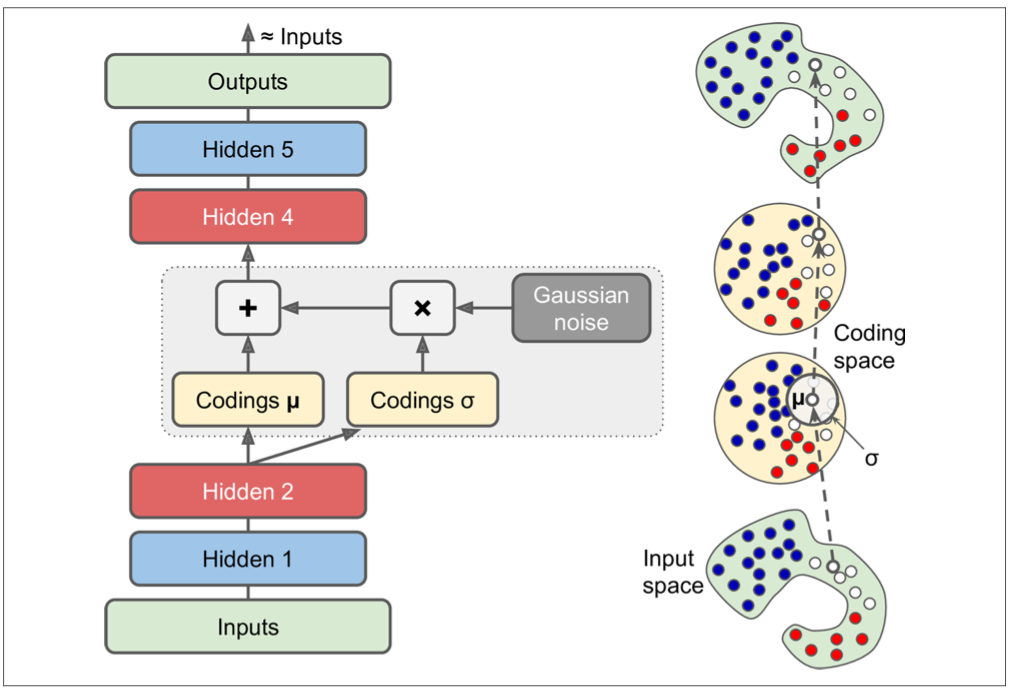

## Dataset MNIST

In [2]:
def get_mnist_data_loaders(batch_size):
    train_ds = tv.datasets.MNIST('/data/datasets/MNIST/', train=True, transform=tv.transforms.ToTensor())
    test_ds = tv.datasets.MNIST('/data/datasets/MNIST/', train=False, transform=tv.transforms.ToTensor())
    print('Número de amostras no dataset (treino):', len(train_ds))
    print('Número de amostras no dataset (teste): ', len(test_ds))
    train_dloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_dloader =  DataLoader(train_ds, batch_size=batch_size, shuffle=False)
    return train_dloader, test_dloader

## O autocodificador

In [3]:
class VAE(nn.Module):
    def __init__(self, flatten_dim, latent_dim, intermediate_dim):
        super(VAE, self).__init__()

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.fc1  = nn.Linear(flatten_dim, intermediate_dim)
        self.fc21 = nn.Linear(intermediate_dim, latent_dim)
        self.fc22 = nn.Linear(intermediate_dim, latent_dim)
        self.fc3  = nn.Linear(latent_dim, intermediate_dim)
        self.fc4  = nn.Linear(intermediate_dim, flatten_dim)

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
          std = logvar.mul(0.5).exp_()
          eps = Variable(std.data.new(std.size()).normal_())
          return eps.mul(std).add_(mu)
        else:
          return mu

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


## A função de custo

In [4]:
def vae_loss(recon_x, x, mu, logvar, batch_size, flatten_dim):
    # (1) cross-entropy
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, flatten_dim))

    # (2) Kullback–Leibler divergence
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Normalise by same number of elements as in reconstruction
    KLD /= batch_size * flatten_dim

    return BCE + KLD


## Funções para treinamento e teste

In [5]:
def train_epoch(epoch, model, optim, loss_fun, data_loader, log_interval=200):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(data_loader):
        if use_gpu:
            data = data.cuda()
        data = Variable(data)
            
        optim.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_fun(recon_batch, data, mu, logvar, batch_size, flatten_dim)
        loss.backward()
        optim.step()
        
        train_loss += loss.data[0]
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{:3d}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx, len(data_loader),
                100. * batch_idx / len(data_loader), loss.data[0] / len(data)))

    print('====> Epoch: {}    Average loss: {:.4f}'.format(epoch, 
                                                           train_loss / len(data_loader.dataset)))


def test_epoch(epoch, model, loss_fun, data_loader):
    model.eval()
    test_loss = 0
    for i, (data, _) in enumerate(data_loader):
        if use_gpu:
            data = data.cuda()
        data = Variable(data, volatile=True)
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar, batch_size, flatten_dim)
        test_loss += loss.data[0]
        
        if i == 0:
            n = min(data.size(0), 8)
            comparison = torch.cat([data[:n], recon_batch.view(batch_size, 1, 28, 28)[:n]])
            save_image(comparison.data.cpu(), 'images/vae_recon_{:03d}.png'.format(epoch), nrow=n)            

    test_loss /= len(data_loader.dataset)
    print('====> Epoch: {}   Test set loss: {:.4f}'.format(epoch, test_loss))

## Treinamento

In [6]:
trainIt = True
n_epochs = 15
batch_size = 100
flatten_dim = 784
latent_dim = 20
intermediate_dim = 512

tra_loader, tst_loader = get_mnist_data_loaders(batch_size)
vae_net = VAE(flatten_dim, latent_dim, intermediate_dim)
optimizer = Adam(vae_net.parameters(), lr=1e-3)

if use_gpu:
    vae_net = vae_net.cuda()

Número de amostras no dataset (treino): 60000
Número de amostras no dataset (teste):  10000


In [7]:
if trainIt:
    try:
        for epoch in range(1, n_epochs + 1):
            train_epoch(epoch, vae_net, optimizer, vae_loss, tra_loader)
            test_epoch(epoch, vae_net, vae_loss, tst_loader)

    except KeyboardInterrupt:
        print('interrupted!')

    torch.save(vae_net.state_dict(), 'models/vae_mnist.model')
    
else:
    vae_net.load_state_dict(torch.load('models/vae_mnist.model', map_location=lambda a, b: a))
    

Train Epoch: 1 [  0/600 (0%)]	Loss: 0.006972
Train Epoch: 1 [200/600 (33%)]	Loss: 0.001954
Train Epoch: 1 [400/600 (67%)]	Loss: 0.001610
====> Epoch: 1    Average loss: 0.0019
====> Epoch: 1   Test set loss: 0.0015
Train Epoch: 2 [  0/600 (0%)]	Loss: 0.001604
Train Epoch: 2 [200/600 (33%)]	Loss: 0.001493
Train Epoch: 2 [400/600 (67%)]	Loss: 0.001470
====> Epoch: 2    Average loss: 0.0015
====> Epoch: 2   Test set loss: 0.0013
Train Epoch: 3 [  0/600 (0%)]	Loss: 0.001467
Train Epoch: 3 [200/600 (33%)]	Loss: 0.001520
Train Epoch: 3 [400/600 (67%)]	Loss: 0.001424
====> Epoch: 3    Average loss: 0.0014
====> Epoch: 3   Test set loss: 0.0013
Train Epoch: 4 [  0/600 (0%)]	Loss: 0.001401
Train Epoch: 4 [200/600 (33%)]	Loss: 0.001465
Train Epoch: 4 [400/600 (67%)]	Loss: 0.001430
====> Epoch: 4    Average loss: 0.0014
====> Epoch: 4   Test set loss: 0.0013
Train Epoch: 5 [  0/600 (0%)]	Loss: 0.001346
Train Epoch: 5 [200/600 (33%)]	Loss: 0.001384
Train Epoch: 5 [400/600 (67%)]	Loss: 0.001367
===

## Avaliação

### A reconstrução ao longo do treinamento

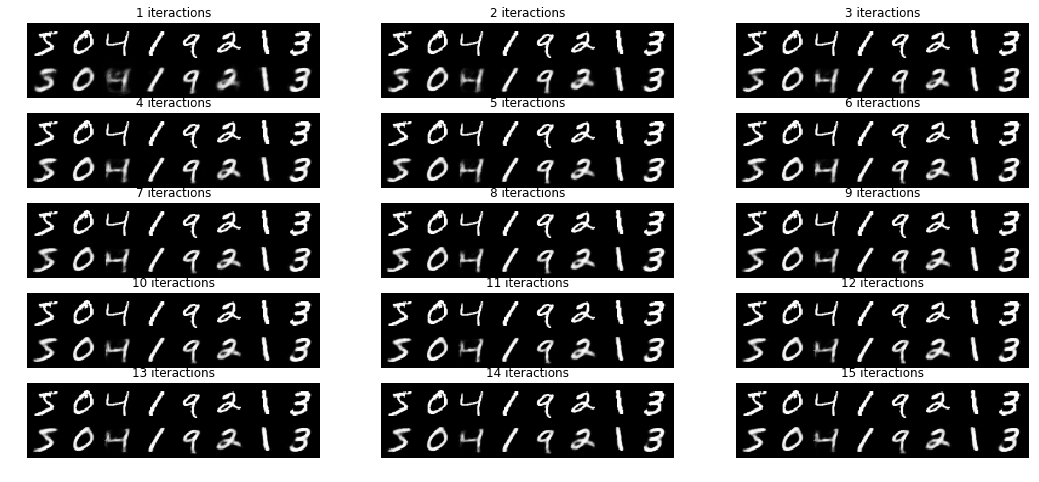

In [24]:
fig = plt.figure(figsize=(18, 8))

for i, fn in enumerate(range(1, n_epochs+1)):
    fig.add_subplot(5, 3, i+1)
    image_fn = 'images/vae_recon_{:03d}.png'.format(fn)
    img = plt.imread(image_fn)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('{} iteractions'.format(fn))
 

### Explorando o espaço da codificação

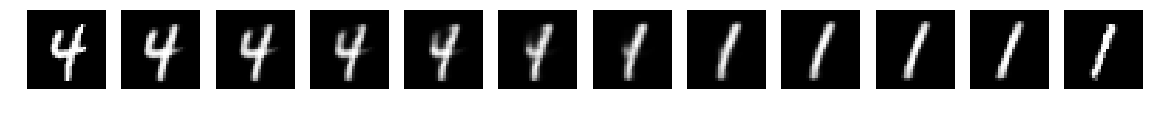

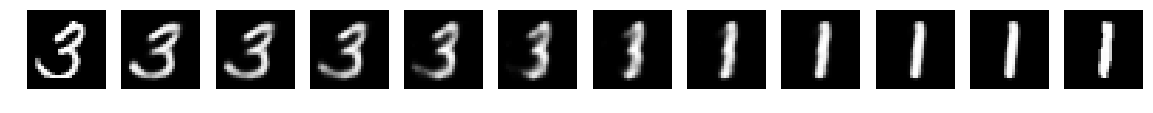

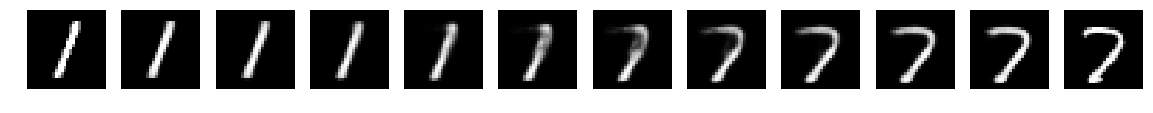

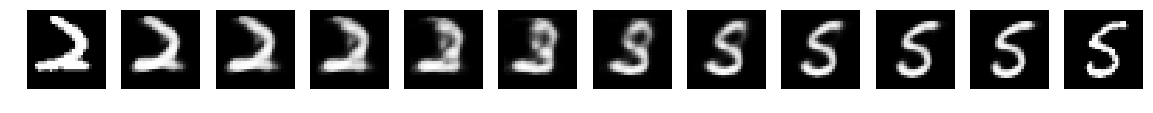

In [25]:
n = 10
for i in range(4):
    a = nr.randint(0, len(tst_loader.dataset))
    b = nr.randint(0, len(tst_loader.dataset))

    fig = plt.figure(figsize=(20, 2))

    img1, _ = tst_loader.dataset[a]
    img2, _ = tst_loader.dataset[b]

    plt.subplot(1, n+2, 1)
    plt.imshow(img1[0].numpy(), cmap=plt.cm.gray)
    plt.axis('off')
    plt.subplot(1, n+2, n+2)
    plt.imshow(img2[0].numpy(), cmap=plt.cm.gray)
    plt.axis('off')

    images = Variable(torch.cat([img1, img2]).view(2, -1))
    if use_gpu:
        images = images.cuda()
    (code_a, code_b), _ = vae_net.encode(images)

    vec = code_b - code_a
    for i, q in enumerate(torch.linspace(0.0, 1.0, n)):
        v = code_a + q * vec
        v = torch.unsqueeze(v, 0)
        img = vae_net.decode(v)
        img = img.view(img1.shape)
        plt.subplot(1, n+2, i+2)
        plt.imshow(img.data.cpu().numpy()[0], cmap=plt.cm.gray)
        plt.axis('off')